<a href="https://colab.research.google.com/github/Linameji88/miSitio/blob/main/parcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelo de Propagación de Epidemias con Dinámica en Red

### Introducción
El presente informe describe la implementación y análisis de un modelo de propagación de epidemias utilizando una cuadrícula bidimensional con condiciones de frontera toroidales. Se modela la interacción entre individuos susceptibles, infectados y recuperados a través de reglas probabilísticas de infección y recuperación.

### Definición del Modelo
El modelo se basa en una variante del modelo SIR, donde cada individuo se encuentra en uno de los siguientes estados:

- \( S \) - **Susceptible**: Puede infectarse si entra en contacto con un individuo infectado.
- \( I \) - **Infectado**: Puede transmitir la enfermedad a sus vecinos con una probabilidad \( p_{\text{infect}} \).
- \( R \) - **Recuperado**: No puede volver a infectarse.

### Reglas de Transición
La evolución del sistema se define por las siguientes reglas:

#### Infección
Un individuo susceptible (\( S \)) se infecta si tiene al menos un vecino infectado en su *vecindad de Von Neumann* (arriba, abajo, izquierda o derecha). La probabilidad de infección está dada por:

\[
P(S \to I) = 1 - (1 - p_{\text{infect}})^{n_I}
\]

donde:
- \( p_{\text{infect}} = 0.3 \) es la probabilidad base de transmisión.
- \( n_I \) es el número de vecinos infectados.

#### Recuperación
Un individuo infectado (\( I \)) se recupera con una probabilidad \( p_{\text{recover}} \) después de \( T_{\text{recovery}} \) pasos:

\[
P(I \to R) = p_{\text{recover}}
\]

donde \( p_{\text{recover}} = \frac{1}{T_{\text{recovery}}} \) y \( T_{\text{recovery}} = 5 \).

#### Condiciones de Frontera
Se utilizan condiciones de frontera toroidales, de modo que la cuadrícula es tratada como un toro:

\[
G(i, j) = G((i + N) \mod N, (j + N) \mod N)
\]

Esto permite que las interacciones sean continuas sin bordes fijos.

## Implementación
El modelo se implementó en **Python** utilizando las siguientes bibliotecas:

- **NumPy**: Para la representación y manipulación de la cuadrícula.
- **Matplotlib**: Para la visualización de la evolución del sistema.

### Inicialización
Se definió una cuadrícula de tamaño \( N \times N \) con \( N = 50 \), donde:
- Un 5% de los individuos son inicializados como **infectados** (\( I \)).
- El resto de los individuos son **susceptibles** (\( S \)).
- No hay individuos **recuperados** (\( R \)) al inicio.

### Evolución del Sistema
Para cada paso de tiempo \( t \), se aplican las siguientes reglas:
1. Movimiento aleatorio de los individuos con condiciones toroidales.
2. Evaluación de infecciones basadas en la probabilidad \( P(S \to I) \).
3. Evaluación de recuperaciones con \( P(I \to R) \).

### Visualización
Se generó una animación utilizando Matplotlib, mostrando:

- El estado de la cuadrícula, donde:
  - 🟩 Verde representa individuos **susceptibles**.
  - 🟥 Rojo representa individuos **infectados**.
  - ⬜ Gris representa individuos **recuperados**.
- Un gráfico de evolución temporal de las proporciones \( S, I, R \).

## Resultados
La simulación muestra un comportamiento característico de epidemias:

- En las primeras iteraciones, la infección se propaga rápidamente.
- Al alcanzar un punto crítico, la cantidad de infectados disminuye debido a la recuperación.
- Finalmente, la población converge hacia un estado estable con individuos mayormente recuperados.

### Curvas de Evolución
Se obtuvo un gráfico con la evolución de \( S, I, R \) en función del tiempo, observando que:
- La cantidad de infectados alcanza un pico antes de disminuir.
- La población recuperada crece a medida que más individuos se recuperan.
- La cantidad de susceptibles disminuye conforme la infección avanza.

## Conclusión

La evolución observada es consistente con modelos epidemiológicos básicos, mostrando la importancia de la recuperación en la dinámica de propagación. Futuras extensiones podrían incluir variantes como la introducción de individuos vacunados o la variación de las tasas de infección y recuperación en el tiempo.


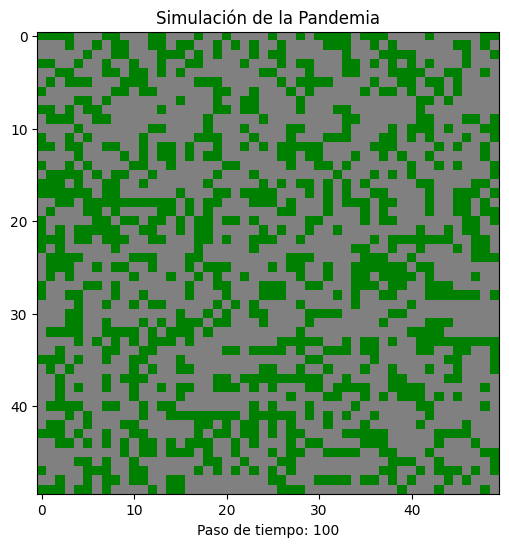

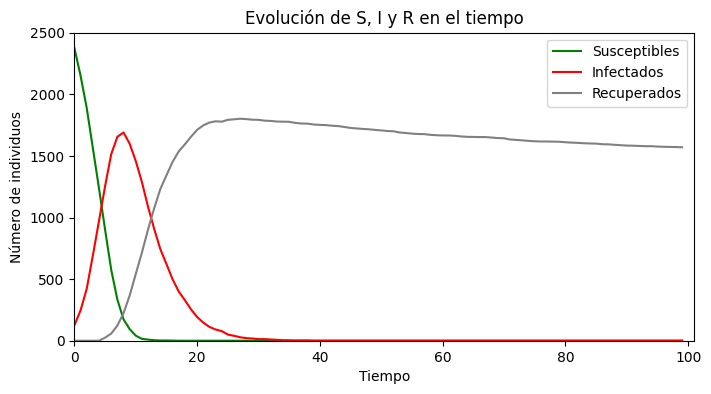

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
from IPython.display import HTML

# ---------------------- Parámetros de la simulación ---------------------- #
N = 50                              # Tamaño del grid (N x N)
p_infectar = 0.3                    # Probabilidad base de infección
T_recuperacion = 5                  # Tiempo (pasos) tras el cual un infectado puede recuperarse
p_recuperar = 1 / T_recuperacion    # Probabilidad de recuperación una vez cumplido T_recuperacion
porc_infectados_inicial = 0.05      # Porcentaje inicial de infectados
num_pasos = 100                     # Número de pasos de tiempo de la simulación

# Estados:
# 0 = Susceptible, 1 = Infectado, 2 = Recuperado

# ---------------------- Inicialización del sistema ---------------------- #
# Se crea la matriz de estados y la de tiempo infectado (para los infectados)
estado = np.zeros((N, N), dtype=int)            # Todos comienzan como susceptibles (0)
tiempo_infectado = np.zeros((N, N), dtype=int)    # Contador de pasos infectados (solo relevante en estado 1)

# Seleccionar aleatoriamente el 5% de la población para estar infectada inicialmente
num_infectados = int(N * N * porc_infectados_inicial)
indices = np.random.choice(N * N, num_infectados, replace=False)
estado_flat = estado.flatten()
estado_flat[indices] = 1
estado = estado_flat.reshape((N, N))

# Se guardan los estados y los conteos para generar las animaciones
historial_estado = [estado.copy()]
lista_S = [np.sum(estado == 0)]
lista_I = [np.sum(estado == 1)]
lista_R = [np.sum(estado == 2)]

# ---------------------- Configuración del movimiento ---------------------- #
# Se definen los posibles desplazamientos (dx, dy)
# Se desea que la probabilidad de (0,0) (quedarse quieto) sea 1/6 y para cada uno de los otros 8 movimientos sea 5/48.
movimientos = np.array([
    [ 0,  0],  # Quedarse quieto
    [ 0,  1],
    [ 0, -1],
    [ 1,  0],
    [-1,  0],
    [ 1,  1],
    [ 1, -1],
    [-1,  1],
    [-1, -1]
])
# Pesos asociados: [1/6] para (0,0) y 5/48 para cada uno de los otros 8 movimientos.
pesos = np.array([1/6] + [5/48] * 8)
pesos_acum = np.cumsum(pesos)  # Para muestreo con la técnica de la distribución acumulada


# ---------------------- Función para seleccionar movimiento aleatorio ---------------------- #
def elegir_movimiento():
    r = np.random.rand()
    indice = np.searchsorted(pesos_acum, r)
    return movimientos[indice]

# ---------------------- Función de actualización de la simulación ---------------------- #
def actualizar(estado, tiempo_infectado):
    """
    Realiza un paso de tiempo de la simulación:
      1. Movimiento: cada individuo se mueve a una posición adyacente según la distribución establecida.
         Se resuelven conflictos de forma que si la celda destino ya está ocupada, se intenta colocar
         al individuo en su celda original o, en última instancia, en la primera celda vacía encontrada.
      2. Infección y recuperación:
         - Un susceptible (0) se infecta con probabilidad 1 - (1 - p_infectar)^(n_infectados_vecinos)
           si tiene al menos un vecino infectado (considerando la vecindad de Von Neumann).
         - Un infectado (1) incrementa su contador; si alcanza T_recuperacion, se recupera con probabilidad p_recuperar.

    Retorna los nuevos arrays: (estado_actualizado, tiempo_infectado_actualizado)
    """
    # Paso 1: Movimiento
    nuevo_estado = -1 * np.ones_like(estado)      # Usamos -1 para marcar celdas vacías temporalmente
    nuevo_tiempo = np.zeros_like(tiempo_infectado)

    # Se genera una lista de índices (i, j) y se baraja para actualizar en orden aleatorio
    indices_celdas = [(i, j) for i in range(N) for j in range(N)]
    np.random.shuffle(indices_celdas)

    for i, j in indices_celdas:
        dx, dy = elegir_movimiento()
        i_nuevo = (i + dx) % N
        j_nuevo = (j + dy) % N
        if nuevo_estado[i_nuevo, j_nuevo] == -1:
            # Si la celda destino está vacía, se mueve el individuo allí.
            nuevo_estado[i_nuevo, j_nuevo] = estado[i, j]
            nuevo_tiempo[i_nuevo, j_nuevo] = tiempo_infectado[i, j]
        else:
            # Si la celda destino ya está ocupada, se intenta colocar en la celda original.
            if nuevo_estado[i, j] == -1:
                nuevo_estado[i, j] = estado[i, j]
                nuevo_tiempo[i, j] = tiempo_infectado[i, j]
            else:
                # Si ambas están ocupadas, se buscan celdas vacías en el entorno
                encontrado = False
                for mov in movimientos:
                    i_cand = (i + mov[0]) % N
                    j_cand = (j + mov[1]) % N
                    if nuevo_estado[i_cand, j_cand] == -1:
                        nuevo_estado[i_cand, j_cand] = estado[i, j]
                        nuevo_tiempo[i_cand, j_cand] = tiempo_infectado[i, j]
                        encontrado = True
                        break
                if not encontrado:
                    # Si no se encuentra celda vacía, se fuerza la asignación en la celda destino (sobrescribe)
                    nuevo_estado[i_nuevo, j_nuevo] = estado[i, j]
                    nuevo_tiempo[i_nuevo, j_nuevo] = tiempo_infectado[i, j]

    # Paso 2: Actualización de infecciones y recuperaciones
    estado_actualizado = nuevo_estado.copy()
    tiempo_actualizado = nuevo_tiempo.copy()

    for i in range(N):
        for j in range(N):
            # Caso 1: Individuo susceptible
            if nuevo_estado[i, j] == 0:
                # Vecinos de Von Neumann: arriba, abajo, izquierda, derecha
                vecinos = [((i - 1) % N, j), ((i + 1) % N, j), (i, (j - 1) % N), (i, (j + 1) % N)]
                n_infectados = sum(1 for vi, vj in vecinos if nuevo_estado[vi, vj] == 1)
                prob_infeccion = 1 - (1 - p_infectar) ** n_infectados
                if np.random.rand() < prob_infeccion:
                    estado_actualizado[i, j] = 1  # Se infecta
                    tiempo_actualizado[i, j] = 0  # Reinicia contador de infección

            # Caso 2: Individuo infectado
            elif nuevo_estado[i, j] == 1:
                tiempo_actualizado[i, j] += 1  # Incrementa contador
                if tiempo_actualizado[i, j] >= T_recuperacion:
                    if np.random.rand() < p_recuperar:
                        estado_actualizado[i, j] = 2  # Se recupera
                        tiempo_actualizado[i, j] = 0
    return estado_actualizado, tiempo_actualizado

# ---------------------- Ejecución de la simulación ---------------------- #
for paso in range(num_pasos):
    estado, tiempo_infectado = actualizar(estado, tiempo_infectado)
    historial_estado.append(estado.copy())
    lista_S.append(np.sum(estado == 0))
    lista_I.append(np.sum(estado == 1))
    lista_R.append(np.sum(estado == 2))

# ---------------------- Animación del grid de la simulación d ela evolución pandemica---------------------- #
fig1, ax1 = plt.subplots(figsize=(6, 6))
cmap = ListedColormap(['green', 'red', 'gray'])
imagen = ax1.imshow(historial_estado[0], cmap=cmap, vmin=0, vmax=2)
ax1.set_title('Simulación de la Pandemia')

def animar_grid(frame):
    imagen.set_data(historial_estado[frame])
    ax1.set_xlabel(f'Paso de tiempo: {frame}')
    return [imagen]

animacion_grid = animation.FuncAnimation(fig1, animar_grid, frames=len(historial_estado),
                                         interval=200, blit=True)

# Mostrar la animación en Colab (HTML5 video)

display(HTML(animacion_grid.to_html5_video()))


# ---------------------- Gráfica de la evolución de S, I y R ---------------------- #
fig2, ax2 = plt.subplots(figsize=(8, 4))
eje_tiempo = np.arange(len(historial_estado))

# Inicializamos las líneas vacías para actualizar en la animación
linea_S, = ax2.plot([], [], color='green', label='Susceptibles')
linea_I, = ax2.plot([], [], color='red', label='Infectados')
linea_R, = ax2.plot([], [], color='gray', label='Recuperados')

ax2.set_xlim(0, len(historial_estado))
ax2.set_ylim(0, N * N)
ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Número de individuos')
ax2.set_title('Evolución de S, I y R en el tiempo')
ax2.legend()

# Función de animación
def actualizar(frame):
    linea_S.set_data(eje_tiempo[:frame], lista_S[:frame])
    linea_I.set_data(eje_tiempo[:frame], lista_I[:frame])
    linea_R.set_data(eje_tiempo[:frame], lista_R[:frame])
    return linea_S, linea_I, linea_R

# Crear animación
animacion_sir = animation.FuncAnimation(fig2, actualizar, frames=len(historial_estado),
                                        interval=200, blit=True)

# Mostrar la animación en Colab
display(HTML(animacion_sir.to_html5_video()))
